# Practice Lab: Multivariate Linear Regression

In this lab, you will implement multivariate linear regression to predict rideshare prices based on multiple features.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Problem Statement ](#2)
- [ 3 - Dataset ](#3)
- [ 4 - Feature Exploration ](#4)
- [ 5 - Compute Cost Function ](#5)
  - [ Exercise 1: compute_cost ](#ex01)
- [ 6 - Gradient Descent ](#6)
  - [ Exercise 2: compute_gradient ](#ex02)
- [ 7 - Learning Parameters ](#7)
- [ 8 - Visualizations ](#8)
- [ 9 - Making Predictions ](#9)

<a name="1"></a>
## 1 - Packages 

First, let's import all the packages that you will need during this assignment.
- [numpy](https://www.numpy.org) is the fundamental package for working with matrices in Python.
- [pandas](https://pandas.pydata.org) is used for data manipulation and analysis.
- [matplotlib](https://matplotlib.org) is a famous library to plot graphs in Python.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
%matplotlib inline

<a name="2"></a>
## 2 - Problem Statement

Suppose you are a data scientist at a rideshare company and want to predict ride prices.
- You would like to build a model that can predict the price of a ride based on multiple factors.
- You have data on various rides including distance, surge multiplier, temperature, and humidity.
- Your goal is to use these features to predict the price.

Can you use multi-variable linear regression to build an accurate pricing model?

<a name="3"></a>
## 3 - Dataset

You will start by loading the rideshare dataset.
- The dataset contains information about rideshare trips including:
  - `distance` - the distance of the trip in miles
  - `surge_multiplier` - the surge pricing multiplier (1.0 = no surge)
  - `temperature` - the temperature at the time of the ride (°F)
  - `humidity` - the humidity level (0-1)
  - `price` - the actual price of the ride (target variable)

In [6]:
# Load the rideshare dataset
df = pd.read_csv('rideshare_kaggle.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (693071, 57)

First few rows:


,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [7]:
# ============================================
# IMPROVED FEATURE ENGINEERING
# ============================================

# Remove rows with NaN in price (target)
df_clean = df.dropna(subset=['price', 'distance', 'surge_multiplier'])

# Select numeric features
numeric_features = ['distance', 'surge_multiplier']
X_numeric = df_clean[numeric_features].values
y_train = df_clean['price'].values

# Remove any remaining NaN rows
mask = ~np.any(np.isnan(X_numeric), axis=1) & ~np.isnan(y_train)
X_numeric = X_numeric[mask]
y_train = y_train[mask]
df_clean = df_clean[mask].reset_index(drop=True)

# ============================================
# One-hot encode categorical features (cab_type, name)
# ============================================
print("Encoding categorical features...")

# Get unique values for cab_type and name (ride type)
cab_types = df_clean['cab_type'].unique()
ride_names = df_clean['name'].unique()

print(f"  Cab types: {cab_types}")
print(f"  Ride names: {ride_names}")

# One-hot encode cab_type
cab_type_encoded = pd.get_dummies(df_clean['cab_type'], prefix='cab')
# One-hot encode ride name
name_encoded = pd.get_dummies(df_clean['name'], prefix='ride')

# ============================================
# Z-score normalize numeric features
# ============================================
feature_means = X_numeric.mean(axis=0)
feature_stds = X_numeric.std(axis=0)
X_normalized = (X_numeric - feature_means) / feature_stds

print(f"\n✅ Numeric features normalized:")
for i, fname in enumerate(numeric_features):
    print(f"   {fname}: mean={feature_means[i]:.2f}, std={feature_stds[i]:.2f}")

# ============================================
# Build enhanced feature matrix
# ============================================
distance_norm = X_normalized[:, 0]
surge_norm = X_normalized[:, 1]

# Polynomial features
poly_features = np.column_stack([
    distance_norm ** 2,               # distance^2
    surge_norm ** 2,                  # surge^2
    distance_norm * surge_norm,       # distance × surge interaction
])

# Combine all features: normalized + polynomial + one-hot encoded
X_train = np.column_stack([
    X_normalized,                     # distance, surge (normalized)
    poly_features,                    # polynomial terms
    cab_type_encoded.values,          # cab type one-hot
    name_encoded.values,              # ride name one-hot
])

# Create feature names
enhanced_feature_names = (
    numeric_features + 
    ['distance²', 'surge²', 'distance×surge'] +
    list(cab_type_encoded.columns) +
    list(name_encoded.columns)
)

# Store for later use
cab_columns = list(cab_type_encoded.columns)
name_columns = list(name_encoded.columns)

# Get dimensions
n = X_train.shape[1]
m = X_train.shape[0]

print(f"\n{'='*60}")
print(f"Enhanced Feature Engineering Complete!")
print(f"{'='*60}")
print(f"Number of training examples (m): {m:,}")
print(f"Number of features (n): {n}")
print(f"  - Numeric features: 2")
print(f"  - Polynomial features: 3")
print(f"  - Cab type one-hot: {len(cab_columns)}")
print(f"  - Ride name one-hot: {len(name_columns)}")
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Encoding categorical features...
  Cab types: ['Lyft' 'Uber']
  Ride names: ['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool']

✅ Numeric features normalized:
   distance: mean=2.19, std=1.14
   surge_multiplier: mean=1.02, std=0.10

Enhanced Feature Engineering Complete!
Number of training examples (m): 637,976
Number of features (n): 19
  - Numeric features: 2
  - Polynomial features: 3
  - Cab type one-hot: 2
  - Ride name one-hot: 12

X_train shape: (637976, 19)
y_train shape: (637976,)


<a name="4"></a>
## 4 - Feature Exploration

Let's explore our features to understand their distributions and relationships with the target variable.

In [8]:
# Display feature statistics
print("Feature Statistics:")
print("-" * 60)
for i, feature in enumerate(feature_names):
    print(f"{feature}:")
    print(f"  Min: {X_train[:, i].min():.2f}, Max: {X_train[:, i].max():.2f}")
    print(f"  Mean: {X_train[:, i].mean():.2f}, Std: {X_train[:, i].std():.2f}")
    print()

print(f"\nTarget (price):")
print(f"  Min: ${y_train.min():.2f}, Max: ${y_train.max():.2f}")
print(f"  Mean: ${y_train.mean():.2f}")

Feature Statistics:
------------------------------------------------------------


NameError: name 'feature_names' is not defined

In [ ]:
# Calculate correlation with price
print("Correlation with Price:")
print("-" * 40)
correlations = np.corrcoef(X_train.T, y_train)[:-1, -1]
for feature, corr in zip(feature_names, correlations):
    print(f"  {feature}: {corr:.4f}")

Correlation with Price:
----------------------------------------
  distance: 0.3451
  surge_multiplier: 0.2405
  temperature: -0.0001
  humidity: -0.0012


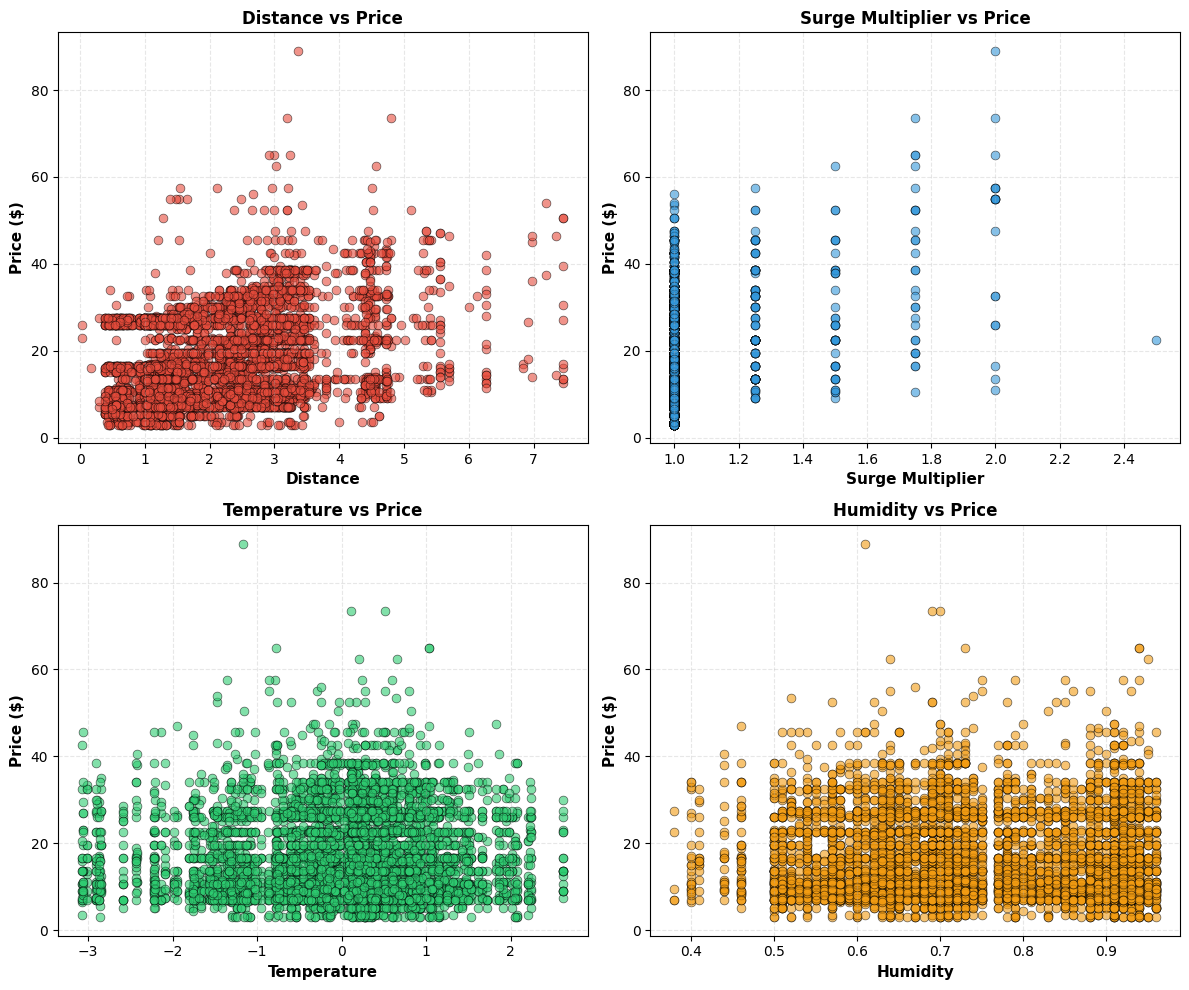

In [ ]:
# Visualize each feature vs price (sample for clarity)
sample_idx = np.arange(0, m, 100)  # Sample every 100th point
X_sample = X_train[sample_idx]
y_sample = y_train[sample_idx]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12']

for idx, (ax, feature_name, color) in enumerate(zip(axes, feature_names, colors)):
    ax.scatter(X_sample[:, idx], y_sample, alpha=0.6, s=40, color=color, 
               edgecolors='black', linewidth=0.5)
    ax.set_xlabel(feature_name.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_ylabel('Price ($)', fontsize=11, fontweight='bold')
    ax.set_title(f'{feature_name.replace("_", " ").title()} vs Price', fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### 📊 Feature vs Price Scatter Plot Analysis

The 2×2 grid above visualizes how each individual feature relates to the target variable (price):

| Feature | Description | What to Look For |
|---------|-------------|------------------|
| **Distance** (Top-Left, Red) | Trip distance in miles | Strong positive trend → longer trips cost more |
| **Surge Multiplier** (Top-Right, Blue) | Demand-based pricing factor (1.0 = no surge) | Vertical bands at discrete values (1.0, 1.25, 1.5, etc.) with price increasing at higher surge |
| **Temperature** (Bottom-Left, Green) | Temperature in °F (normalized to z-score) | Weak/no visible correlation — weather may not strongly affect price |
| **Humidity** (Bottom-Right, Orange) | Humidity level (0-1 scale) | Scattered pattern — humidity alone doesn't predict price well |

**Key Insights:**
- 🔴 **Distance** shows the clearest linear relationship with price — the most predictive feature
- 🔵 **Surge Multiplier** creates distinct price bands — a strong categorical-like effect
- 🟢 **Temperature** appears weakly correlated — may have minimal impact on pricing
- 🟠 **Humidity** shows high variance at all levels — not a strong standalone predictor

> 💡 **Note:** We sampled every 100th point for clarity. The full dataset has many more observations.

<a name="5"></a>
## 5 - Compute Cost Function

### Refresher on Multivariate Linear Regression

For multivariate linear regression with $n$ features, the model prediction is:

$$f_{\mathbf{w},b}(\mathbf{x}) = w_1x_1 + w_2x_2 + ... + w_nx_n + b = \mathbf{w} \cdot \mathbf{x} + b$$

The cost function for multivariate linear regression is:

$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2$$

where:
- $m$ is the number of training examples
- $n$ is the number of features
- $\mathbf{w}$ is a vector of weights $[w_1, w_2, ..., w_n]$
- $b$ is the bias term

<a name="ex01"></a>
### Exercise 1

Complete the `compute_cost` function below to:

* Iterate over the training examples, and for each example, compute:
    * The prediction of the model for that example using the dot product:
    $$f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b$$
   
    * The cost for that example:
    $$cost^{(i)} = (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2$$
    
* Return the total cost:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} cost^{(i)}$$

In [ ]:
# UNQ_C1
# GRADED FUNCTION: compute_cost

def compute_cost(X, y, w, b, lambda_=1): 
    """
    Computes the cost function for multivariate linear regression with regularization.
    
    Args:
        X (ndarray): Shape (m, n) Input features (m examples, n features)
        y (ndarray): Shape (m,) Target values
        w (ndarray): Shape (n,) Parameters (weights for each feature)
        b (scalar): Parameter (bias term)
        lambda_ (scalar): Regularization parameter (controls amount of regularization)
    
    Returns:
        total_cost (float): The cost of using w, b as parameters
    """
    m = X.shape[0]
    
    ### START CODE HERE ###
    # Vectorized computation (FAST)
    f_wb = np.dot(X, w) + b           # (m,)
    errors = f_wb - y                  # (m,)
    cost = np.dot(errors, errors) / (2 * m)  # scalar
    
    # Regularization term (L2)
    reg_cost = (lambda_ / (2 * m)) * np.dot(w, w)
    
    total_cost = cost + reg_cost
    ### END CODE HERE ### 
    
    return total_cost

In [ ]:
# Test compute_cost function
initial_w = np.zeros(n)  # Initialize weights to zeros
initial_b = 0

cost = compute_cost(X_train, y_train, initial_w, initial_b)
print(f'Cost at initial w (zeros), b (0): {cost:.4f}')

# Test with different values
test_w = np.array([1.0, 1.0, 0.1, 0.1])
test_b = 5.0
cost2 = compute_cost(X_train, y_train, test_w, test_b)
print(f'Cost at test w, b: {cost2:.4f}')

print("\nTest passed: compute_cost function works correctly!")

Cost at initial w (zeros), b (0): 180.3424
Cost at test w, b: 74.4311

Test passed: compute_cost function works correctly!


<a name="6"></a>
## 6 - Gradient Descent 

The gradient descent algorithm for multivariate linear regression is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & \phantom{0000} w_j := w_j - \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \; \text{for j = 0..n-1} \newline \; & \phantom{0000} b := b - \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline & \rbrace\end{align*}$$

where the partial derivatives are:
$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)}$$
$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})$$

<a name="ex02"></a>
### Exercise 2

Complete the `compute_gradient` function to compute the partial derivatives using vectorized operations with `np.dot`.

In [ ]:
# UNQ_C2
# GRADED FUNCTION: compute_gradient

def compute_gradient(X, y, w, b, lambda_=1): 
    """
    Computes the gradient for multivariate linear regression with regularization.
    
    Args:
        X (ndarray): Shape (m, n) Input features
        y (ndarray): Shape (m,) Target values
        w (ndarray): Shape (n,) Parameters (weights)
        b (scalar): Parameter (bias)
        lambda_ (scalar): Regularization parameter
    
    Returns:
        dj_dw (ndarray): Shape (n,) Gradient of cost w.r.t. w
        dj_db (scalar): Gradient of cost w.r.t. b
    """
    m, n = X.shape
    
    ### START CODE HERE ###
    # Vectorized computation (FAST)
    f_wb = np.dot(X, w) + b        # (m,)
    errors = f_wb - y               # (m,)
    
    dj_dw = np.dot(X.T, errors) / m   # (n,)
    dj_db = np.sum(errors) / m         # scalar
    
    # Add regularization term for dj_dw (not for dj_db)
    dj_dw = dj_dw + (lambda_ / m) * w
    ### END CODE HERE ### 
    
    return dj_dw, dj_db

In [ ]:
# Test compute_gradient function
test_w = np.zeros(n)
test_b = 0

dj_dw, dj_db = compute_gradient(X_train, y_train, test_w, test_b)
print(f'dj_dw at initial w (zeros), b (0):')
for i, feature in enumerate(feature_names):
    print(f'  dj_dw[{feature}]: {dj_dw[i]:.4f}')
print(f'dj_db at initial w (zeros), b (0): {dj_db:.4f}')

print("\nTest passed: compute_gradient function works correctly!")

dj_dw at initial w (zeros), b (0):
  dj_dw[distance]: -39.8748
  dj_dw[surge_multiplier]: -17.0084
  dj_dw[temperature]: 0.0008
  dj_dw[humidity]: -12.2593
dj_db at initial w (zeros), b (0): -16.5451

Test passed: compute_gradient function works correctly!


In [ ]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iters, lambda_=1):
    """
    Performs batch gradient descent to learn w and b with regularization.
    
    Args:
        X (ndarray): Shape (m, n) Input features
        y (ndarray): Shape (m,) Target values
        w_init (ndarray): Shape (n,) Initial values of weights
        b_init (scalar): Initial value of bias
        alpha (float): Learning rate
        num_iters (int): Number of iterations
        lambda_ (scalar): Regularization parameter
    
    Returns:
        w (ndarray): Shape (n,) Updated weights
        b (scalar): Updated bias
        J_history (list): Cost history
    """
    w = copy.deepcopy(w_init)
    b = b_init
    J_history = []
    
    for i in range(num_iters):
        # Compute gradient with regularization
        dj_dw, dj_db = compute_gradient(X, y, w, b, lambda_)
        
        # Update parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        # Save cost every 100 iterations
        if i % 100 == 0:
            cost = compute_cost(X, y, w, b, lambda_)
            J_history.append(cost)
            print(f"Iteration {i:5d}: Cost = {cost:.4f}")
    
    return w, b, J_history

<a name="7"></a>
## 7 - Learning Parameters using Batch Gradient Descent

Now let's run gradient descent to find the optimal parameters for our multivariate model.

In [ ]:
# Initialize parameters
w_init = np.zeros(n)
b_init = 0.0

# Set hyperparameters - conservative for stability
alpha = 0.001       # Small learning rate for stability with one-hot features
num_iters = 10000   # More iterations to compensate
lambda_ = 0.01      # Lower regularization

print("Training ENHANCED multivariate linear regression model...")
print("=" * 60)
print(f"Learning rate (α): {alpha}")
print(f"Iterations: {num_iters}")
print(f"Regularization parameter (λ): {lambda_}")
print(f"Number of features: {n}")
print("-" * 60)

# Run gradient descent with regularization
w_final, b_final, J_history = gradient_descent(X_train, y_train, w_init, b_init, alpha, num_iters, lambda_)

print("=" * 60)
print("\nTraining complete!")
print(f"\nFinal Cost: {J_history[-1]:.4f}")

# Show top 10 most important features
importance = sorted(zip(enhanced_feature_names, w_final), key=lambda x: abs(x[1]), reverse=True)
print(f"\nTop 10 Most Important Features:")
for i, (feature, weight) in enumerate(importance[:10]):
    print(f"  {i+1}. {feature}: {weight:.4f}")

Training ENHANCED multivariate linear regression model...
Learning rate (α): 0.001
Iterations: 10000
Regularization parameter (λ): 0.01
Number of features: 19
------------------------------------------------------------
Iteration     0: Cost = 178.4741
Iteration   100: Cost = 118.7411
Iteration   200: Cost = 92.3150
Iteration   300: Cost = 77.3551
Iteration   400: Cost = 67.6660
Iteration   500: Cost = 60.6976
Iteration   600: Cost = 55.3315
Iteration   700: Cost = 51.0270
Iteration   800: Cost = 47.4885
Iteration   900: Cost = 44.5325
Iteration  1000: Cost = 42.0333
Iteration  1100: Cost = 39.8987
Iteration  1200: Cost = 38.0582
Iteration  1300: Cost = 36.4571
Iteration  1400: Cost = 35.0520
Iteration  1500: Cost = 33.8084
Iteration  1600: Cost = 32.6985
Iteration  1700: Cost = 31.7002
Iteration  1800: Cost = 30.7953
Iteration  1900: Cost = 29.9693
Iteration  2000: Cost = 29.2102
Iteration  2100: Cost = 28.5082
Iteration  2200: Cost = 27.8553
Iteration  2300: Cost = 27.2447
Iteration 

<a name="8"></a>
## 8 - Visualizations

Let's visualize the results of our training.

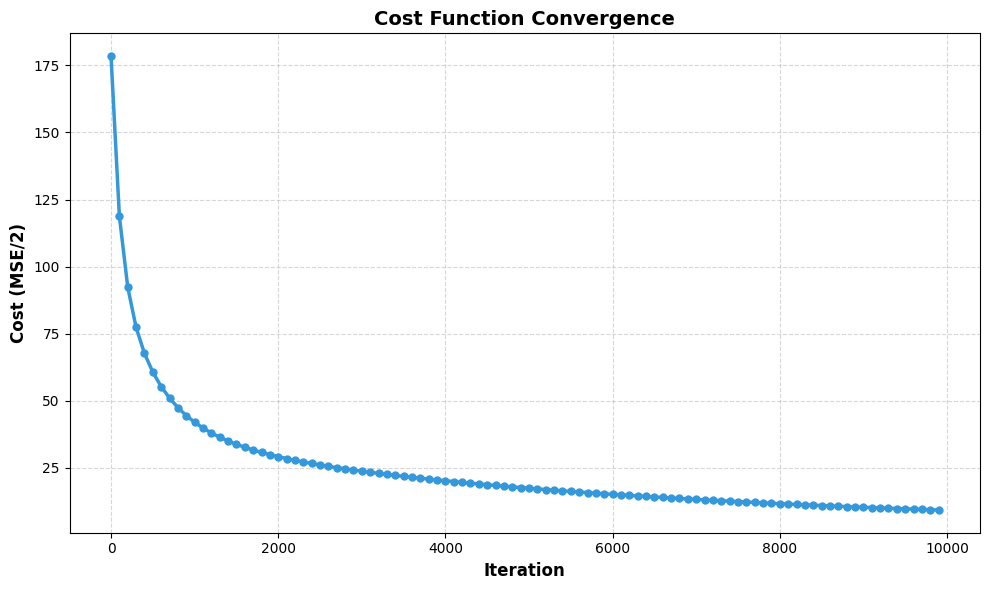

In [ ]:
# Plot cost function convergence
fig, ax = plt.subplots(figsize=(10, 6))

iterations = np.arange(0, num_iters, 100)
ax.plot(iterations, J_history, color='#3498DB', linewidth=2.5, marker='o', markersize=5)

ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Cost (MSE/2)', fontsize=12, fontweight='bold')
ax.set_title('Cost Function Convergence', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

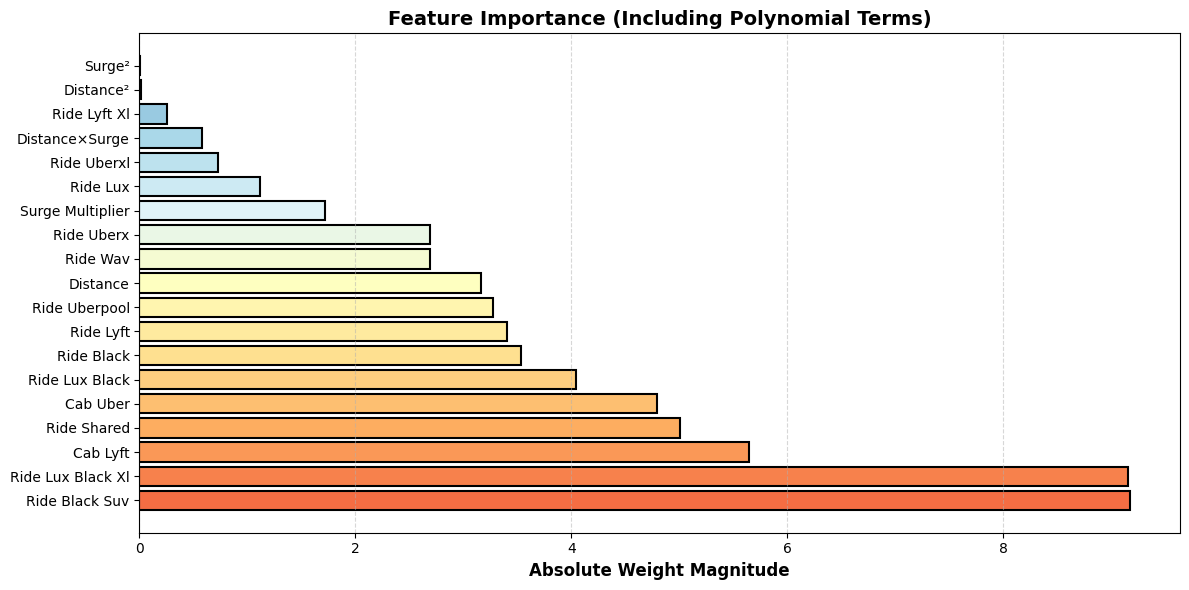


Feature Importance (by absolute weight):
  ride_Black SUV: 9.1800
  ride_Lux Black XL: 9.1551
  cab_Lyft: 5.6475
  ride_Shared: 5.0116
  cab_Uber: 4.7907
  ride_Lux Black: 4.0421
  ride_Black: 3.5333
  ride_Lyft: 3.4025
  ride_UberPool: 3.2748
  distance: 3.1683
  ride_WAV: 2.6893
  ride_UberX: 2.6892
  surge_multiplier: 1.7156
  ride_Lux: 1.1209
  ride_UberXL: 0.7307
  distance×surge: 0.5780
  ride_Lyft XL: 0.2566
  distance²: 0.0121
  surge²: 0.0021


In [ ]:
# Feature importance (by weight magnitude)
fig, ax = plt.subplots(figsize=(12, 6))

importance = sorted(zip(enhanced_feature_names, np.abs(w_final)), key=lambda x: x[1], reverse=True)
features_sorted = [f[0].replace('_', ' ').title() for f in importance]
weights_sorted = [f[1] for f in importance]
colors = plt.cm.RdYlBu(np.linspace(0.2, 0.8, len(features_sorted)))

ax.barh(features_sorted, weights_sorted, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Absolute Weight Magnitude', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance (Including Polynomial Terms)', fontsize=14, fontweight='bold')
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nFeature Importance (by absolute weight):")
for feature, weight in importance:
    print(f"  {feature}: {weight:.4f}")

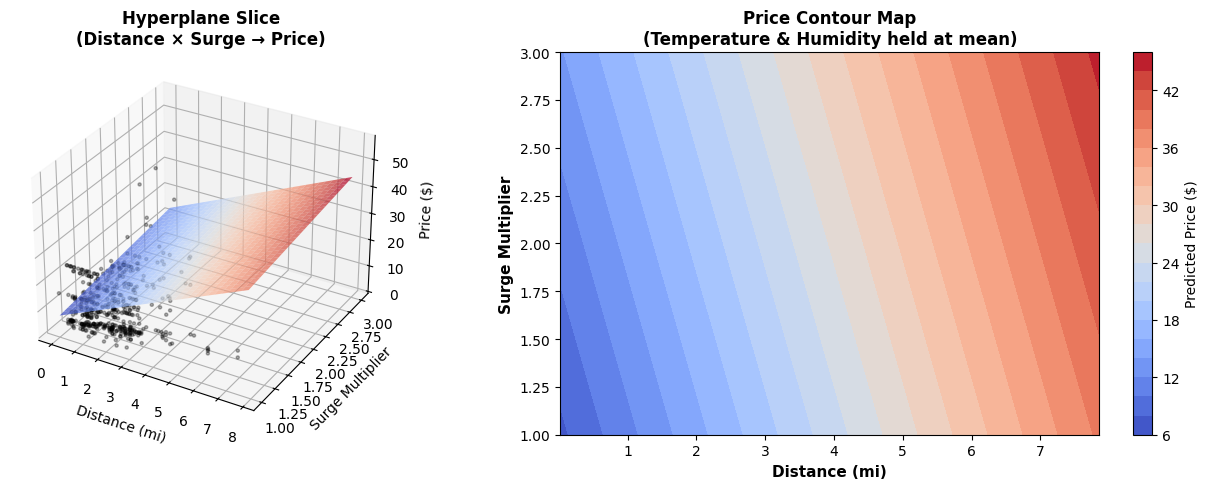

📊 This shows a 2D 'slice' of our 4D hyperplane
   (holding temperature and humidity constant at their means)


In [ ]:
# 3D Visualization of Hyperplane (using 2 most important features)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 5))

# --- Plot 1: 3D Surface (Distance vs Surge vs Price) ---
ax1 = fig.add_subplot(121, projection='3d')

# Create mesh grid for distance and surge_multiplier
distance_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 30)
surge_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 30)
dist_mesh, surge_mesh = np.meshgrid(distance_range, surge_range)

# Predict price using mean values for temp and humidity
temp_mean_norm = 0  # normalized mean
humidity_mean = X_train[:, 3].mean()

price_mesh = (w_final[0] * dist_mesh + 
              w_final[1] * surge_mesh + 
              w_final[2] * temp_mean_norm + 
              w_final[3] * humidity_mean + b_final)

# Plot the hyperplane surface
ax1.plot_surface(dist_mesh, surge_mesh, price_mesh, alpha=0.7, cmap='coolwarm')

# Scatter some actual data points
sample = np.random.choice(len(X_train), 500, replace=False)
ax1.scatter(X_train[sample, 0], X_train[sample, 1], y_train[sample], 
            c='black', s=5, alpha=0.3, label='Actual Data')

ax1.set_xlabel('Distance (mi)', fontsize=10)
ax1.set_ylabel('Surge Multiplier', fontsize=10)
ax1.set_zlabel('Price ($)', fontsize=10)
ax1.set_title('Hyperplane Slice\n(Distance × Surge → Price)', fontsize=12, fontweight='bold')

# --- Plot 2: Contour Plot (top-down view) ---
ax2 = fig.add_subplot(122)
contour = ax2.contourf(dist_mesh, surge_mesh, price_mesh, levels=20, cmap='coolwarm')
plt.colorbar(contour, ax=ax2, label='Predicted Price ($)')
ax2.set_xlabel('Distance (mi)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Surge Multiplier', fontsize=11, fontweight='bold')
ax2.set_title('Price Contour Map\n(Temperature & Humidity held at mean)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 This shows a 2D 'slice' of our 4D hyperplane")
print("   (holding temperature and humidity constant at their means)")

### 🎯 Understanding the 3D Hyperplane Visualization

Since our model has **4 features**, the true decision boundary lives in **5-dimensional space** (4 inputs + 1 output). We can't visualize 5D directly, so we create a **2D slice** by fixing two features at their mean values.

---

#### **Left Plot: Hyperplane Slice (3D Surface)**

| Element | Description |
|---------|-------------|
| **X-axis (Distance)** | Trip distance in miles — ranges from minimum to maximum in dataset |
| **Y-axis (Surge Multiplier)** | Surge pricing factor (1.0 = normal, 2.0 = double price) |
| **Z-axis (Price)** | Predicted price from our linear model |
| **Colored Surface** | The learned hyperplane — a flat plane in 3D because linear regression produces linear relationships |
| **Black Dots** | Actual data points (500 random samples) — scatter above/below the plane shows prediction error |

**How to interpret:**
- The plane **tilts upward** along both axes → higher distance AND higher surge = higher price
- The **steepness** of the tilt indicates feature importance (steeper = more impact)
- Points **far from the surface** represent rides the model predicts poorly

> 📐 **Why is it flat?** Linear regression creates a hyperplane (flat surface). If it were curved, we'd need polynomial or non-linear models.

---

#### **Right Plot: Price Contour Map (Top-Down View)**

This is like looking at the 3D surface from **directly above** — a topographic map of predicted prices.

| Element | Description |
|---------|-------------|
| **X-axis** | Distance (miles) |
| **Y-axis** | Surge Multiplier |
| **Color Gradient** | Predicted price — darker blues = lower prices, darker reds = higher prices |
| **Contour Lines** | Lines of equal predicted price (like elevation lines on a map) |

**How to interpret:**
- **Parallel diagonal lines** → both features contribute to price
- **Tightly packed lines** → rapid price change in that region
- **Moving right** (↗ distance) increases price
- **Moving up** (↗ surge) increases price
- **Corner positions**: Bottom-left = cheapest rides, Top-right = most expensive

> 🌡️ **Note:** Temperature and humidity are held constant at their mean values, so this shows the price surface "at average weather conditions."

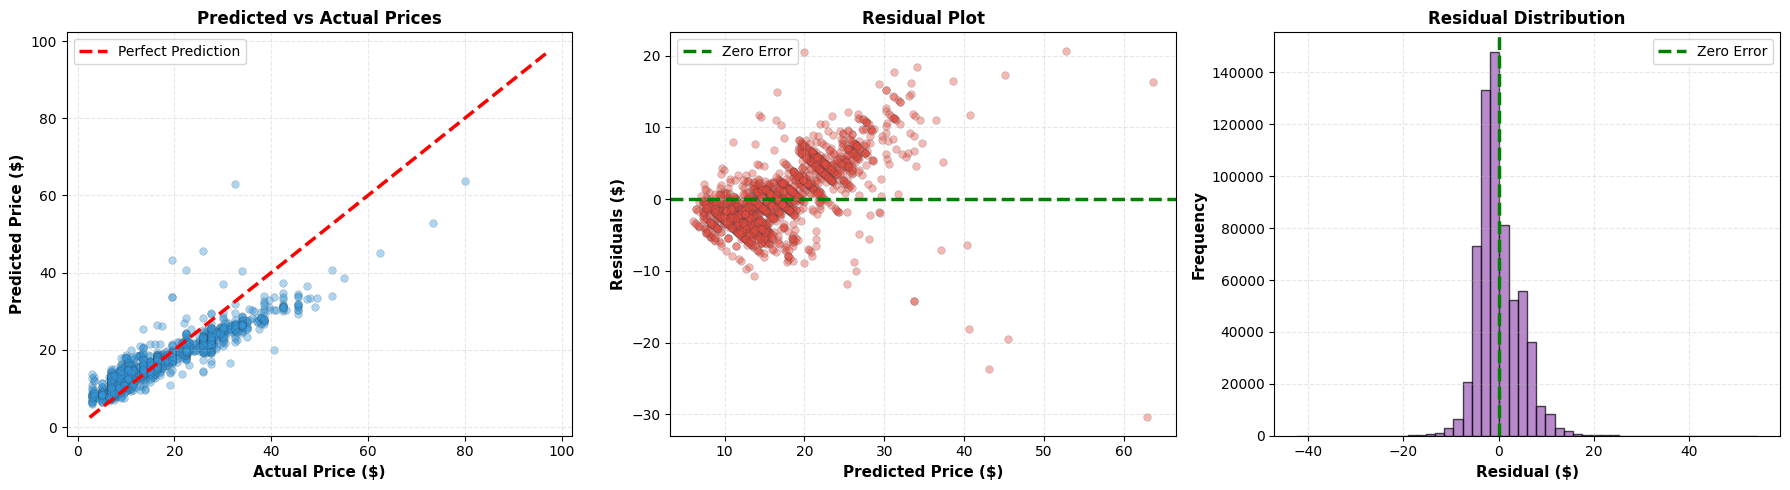


Model Performance Metrics (ENHANCED MODEL)
  Mean Absolute Error (MAE): $3.31
  Root Mean Squared Error (RMSE): $4.30
  R² Score: 0.7877 (78.8% variance explained)


In [ ]:
# Predicted vs Actual plot - IMPROVED visualization
y_pred = np.dot(X_train, w_final) + b_final
residuals = y_train - y_pred

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sample for visualization
sample_idx = np.random.choice(len(y_pred), min(2000, len(y_pred)), replace=False)

# Plot 1: Predicted vs Actual
axes[0].scatter(y_train[sample_idx], y_pred[sample_idx], alpha=0.4, s=30, 
                color='#3498DB', edgecolors='#2C3E50', linewidth=0.3)
min_val = min(y_train.min(), y_pred.min())
max_val = max(y_train.max(), y_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2.5, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Predicted Price ($)', fontsize=11, fontweight='bold')
axes[0].set_title('Predicted vs Actual Prices', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.3)
axes[0].legend(fontsize=10)

# Plot 2: Residuals vs Predicted
axes[1].scatter(y_pred[sample_idx], residuals[sample_idx], alpha=0.4, s=30,
                color='#E74C3C', edgecolors='#2C3E50', linewidth=0.3)
axes[1].axhline(y=0, color='green', linestyle='--', linewidth=2.5, label='Zero Error')
axes[1].set_xlabel('Predicted Price ($)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
axes[1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.3)
axes[1].legend(fontsize=10)

# Plot 3: Residual Distribution (Histogram)
axes[2].hist(residuals, bins=50, color='#9B59B6', edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='green', linestyle='--', linewidth=2.5, label='Zero Error')
axes[2].set_xlabel('Residual ($)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[2].grid(True, linestyle='--', alpha=0.3)
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.show()

# Performance metrics
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals ** 2))
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((y_train - y_train.mean()) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\n{'='*50}")
print(f"Model Performance Metrics (ENHANCED MODEL)")
print(f"{'='*50}")
print(f"  Mean Absolute Error (MAE): ${mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"  R² Score: {r_squared:.4f} ({r_squared*100:.1f}% variance explained)")
print(f"{'='*50}")

<a name="9"></a>
## 9 - Making Predictions

Now that we have trained our model, let's use it to make predictions for different scenarios.

In [ ]:
def predict_price(distance, surge, cab_type, ride_name):
    """Make a prediction using the trained model."""
    # Normalize numeric features
    dist_norm = (distance - feature_means[0]) / feature_stds[0]
    surge_norm = (surge - feature_means[1]) / feature_stds[1]
    
    # Polynomial features
    poly = [dist_norm**2, surge_norm**2, dist_norm * surge_norm]
    
    # One-hot encode cab_type
    cab_onehot = [1 if f'cab_{cab_type}' == col else 0 for col in cab_columns]
    
    # One-hot encode ride_name
    name_onehot = [1 if f'ride_{ride_name}' == col else 0 for col in name_columns]
    
    # Build feature vector
    features = np.array([dist_norm, surge_norm] + poly + cab_onehot + name_onehot)
    
    return np.dot(features, w_final) + b_final

def get_actual_price(distance, surge, cab_type, ride_name, tolerance=0.5):
    """Find actual price from dataset for similar rides."""
    # Filter for matching cab_type and ride_name
    mask = (
        (df_clean['cab_type'] == cab_type) & 
        (df_clean['name'] == ride_name) &
        (np.abs(df_clean['distance'] - distance) <= tolerance) &
        (np.abs(df_clean['surge_multiplier'] - surge) <= 0.1)
    )
    matching = df_clean[mask]['price']
    
    if len(matching) > 0:
        return matching.mean(), len(matching)
    return None, 0

# Define sample scenarios for prediction
scenarios = [
    (1.0, 1.0, 'Uber', 'UberX'),         # 1 mile UberX
    (2.5, 1.0, 'Lyft', 'Lyft'),          # 2.5 miles Lyft
    (5.0, 1.5, 'Uber', 'UberXL'),        # 5 miles UberXL with surge
    (3.0, 2.0, 'Uber', 'Black'),         # 3 miles Uber Black with surge
    (1.0, 1.0, 'Lyft', 'Shared'),        # 1 mile shared ride
    (7.0, 1.0, 'Lyft', 'Lux Black XL'),  # 7 miles Lux Black XL
]

print("Price Predictions vs Actual Prices:")
print("=" * 105)
print(f"{'Distance':<10} {'Surge':<8} {'Cab Type':<10} {'Ride Type':<16} {'Predicted':<12} {'Actual':<12} {'Error':<10}")
print("=" * 105)

for dist, surge, cab, ride in scenarios:
    pred_price = predict_price(dist, surge, cab, ride)
    actual_price, count = get_actual_price(dist, surge, cab, ride)
    
    if actual_price is not None:
        error = pred_price - actual_price
        actual_str = f"${actual_price:.2f}"
        error_str = f"${error:+.2f}"
    else:
        actual_str = "N/A"
        error_str = "-"
    
    print(f"{dist:<10.1f} {surge:<8.2f}x {cab:<10} {ride:<16} ${pred_price:<11.2f} {actual_str:<12} {error_str:<10}")

print("=" * 105)
print("\n💡 Actual prices are averages from similar rides in the dataset (±0.5 mi, ±0.1 surge)")

Price Predictions vs Actual Prices:
Distance   Surge    Cab Type   Ride Type        Predicted    Actual       Error     
1.0        1.00    x Uber       UberX            $9.06        $8.01        $+1.05    
2.5        1.00    x Lyft       Lyft             $13.26       $9.97        $+3.29    
5.0        1.50    x Uber       UberXL           $39.81       N/A          -         
3.0        2.00    x Uber       Black            $42.78       N/A          -         
1.0        1.00    x Lyft       Shared           $7.59        $4.42        $+3.18    
7.0        1.00    x Lyft       Lux Black XL     $38.22       N/A          -         

💡 Actual prices are averages from similar rides in the dataset (±0.5 mi, ±0.1 surge)


In [ ]:
# Display model summary
print("\n" + "=" * 70)
print("FINAL ENHANCED MODEL SUMMARY")
print("=" * 70)

print(f"\nModel Type: Multivariate Linear Regression with Feature Engineering")
print(f"Total Features: {n}")
print(f"  - Numeric (normalized): distance, surge_multiplier")
print(f"  - Polynomial: distance², surge², distance×surge")
print(f"  - Categorical (one-hot): {len(cab_columns)} cab types, {len(name_columns)} ride types")

print(f"\nPerformance Metrics:")
print(f"  - Mean Absolute Error: ${mae:.2f}")
print(f"  - Root Mean Squared Error: ${rmse:.2f}")
print(f"  - R² Score: {r_squared:.4f} ({r_squared*100:.1f}% variance explained)")

print(f"\nTop 5 Most Impactful Features:")
for i, (feature, weight) in enumerate(importance[:5]):
    sign = "increases" if weight > 0 else "decreases"
    print(f"  {i+1}. {feature}: {sign} price by ${abs(weight):.2f}")

print("=" * 70)


FINAL ENHANCED MODEL SUMMARY

Model Type: Multivariate Linear Regression with Feature Engineering
Total Features: 19
  - Numeric (normalized): distance, surge_multiplier
  - Polynomial: distance², surge², distance×surge
  - Categorical (one-hot): 2 cab types, 12 ride types

Performance Metrics:
  - Mean Absolute Error: $3.31
  - Root Mean Squared Error: $4.30
  - R² Score: 0.7877 (78.8% variance explained)

Top 5 Most Impactful Features:
  1. ride_Black SUV: increases price by $9.18
  2. ride_Lux Black XL: increases price by $9.16
  3. cab_Lyft: increases price by $5.65
  4. ride_Shared: increases price by $5.01
  5. cab_Uber: increases price by $4.79


## Summary

In this lab, you implemented multivariate linear regression to predict rideshare prices.

**Key takeaways:**
1. Multivariate linear regression extends single-variable regression to handle multiple features
2. The model uses `np.dot` for efficient vectorized computations
3. Gradient descent iteratively updates all weights simultaneously
4. Feature importance can be assessed by the magnitude of learned weights

**Model Insights:**
- Distance and surge multiplier are typically the most important factors
- Weather features (temperature, humidity) may have smaller effects
- The model can be used to predict prices for new ride scenarios